In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Ensemble

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def _normalize_tabular(df: pd.DataFrame, label_name: str = "label"):
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop(label_name, axis=1))
    y = df[label_name]
    return X, y

def simul_split_train_valid_test(df: pd.DataFrame, train_ratio: float = 0.7):
    X, y = _normalize_tabular(df)
    tmp = pd.DataFrame(X)
    tmp["label"] = y
    normal = tmp.loc[tmp["label"] == 0, :].reset_index(drop=True)
    abnormal = tmp.loc[tmp["label"] == 1, :].reset_index(drop=True)
    X_train, X_val_test, y_train, y_val_test = train_test_split(
        normal.drop("label", axis=1),
        normal["label"],
        train_size=train_ratio,
        random_state=42,
        shuffle=False,
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test, y_val_test, train_size=0.5, random_state=42, shuffle=False
    )
    X_test["label"] = y_test
    X_test = pd.concat([X_test, abnormal]).reset_index(drop=True)
    return (
        X_train.values,
        X_val.values,
        X_test.drop("label", axis=1).values,
        y_train.values,
        y_val.values,
        X_test["label"].values,
    )

In [4]:
[data for data in os.listdir('./sim_data') if ('small' in data) and ('.csv' in data)]

['smallNormal.csv',
 'smallTestNoise_010_01.csv',
 'smallTestNoise_010_05.csv',
 'smallTestNoise_010_09.csv',
 'smallTrainNoise_001_01.csv',
 'smallTrainNoise_001_05.csv',
 'smallTrainNoise_001_09.csv',
 'smallTrainNoise_010_01.csv',
 'smallTrainNoise_010_05.csv',
 'smallTrainNoise_010_09.csv']

In [7]:
def get_ensemble_result(PATH = './ensemble_sim_1/', name = 'smallNormal.csv', n_models=8):
    data = pd.read_csv('./sim_data/'+ name)

    (
        _,
        _,
        _,
        _,
        _,
        test_y,
    ) = simul_split_train_valid_test(data, 0.7)

    name = name.split('.')[0]

    anomaly_score = np.zeros((len(test_y), n_models))

    result_df = pd.DataFrame(columns=['mean','median','max','min'], index=['roc_auc','pr_auc'])


    idx = 0
    for data_name in os.listdir(PATH):
        if name in data_name:
            with open(PATH + data_name, 'rb') as f:
                tmp = pickle.load(f)
                anomaly_score[:, idx] = tmp
                idx += 1

    tst_ano_scr_med = np.median(anomaly_score, axis=1)
    tst_ano_scr_mean = np.mean(anomaly_score, axis=1)
    tst_ano_scr_max = np.max(anomaly_score, axis=1)
    tst_ano_scr_min = np.min(anomaly_score, axis=1)

    idx = 0
    for tst_ano_scr in [tst_ano_scr_mean, tst_ano_scr_med, tst_ano_scr_max, tst_ano_scr_min]:
        roc_auc = roc_auc_score(test_y, tst_ano_scr)
        _precision, _recall, _ = precision_recall_curve(test_y, tst_ano_scr)
        pr_auc = auc(_recall, _precision)
        result_df.iloc[0, idx] = roc_auc
        result_df.iloc[1, idx] = pr_auc
        idx += 1

    return result_df

def get_ensemble_result_big(PATHs = ['./ensemble_sim_1/'], name = 'smallNormal.csv', n_models=8):
    data = pd.read_csv('./sim_data/'+ name)

    (
        _,
        _,
        _,
        _,
        _,
        test_y,
    ) = simul_split_train_valid_test(data, 0.7)

    name = name.split('.')[0]

    anomaly_score = np.zeros((len(test_y), n_models * len(PATHs)))

    result_df = pd.DataFrame(columns=['mean','median','max','min'], index=['roc_auc','pr_auc'])


    idx = 0
    for PATH in PATHs:
        for data_name in os.listdir(PATH):
            if name in data_name:
                with open(PATH + data_name, 'rb') as f:
                    tmp = pickle.load(f)
                    anomaly_score[:, idx] = tmp
                    idx += 1

    tst_ano_scr_med = np.median(anomaly_score, axis=1)
    tst_ano_scr_mean = np.mean(anomaly_score, axis=1)
    tst_ano_scr_max = np.max(anomaly_score, axis=1)
    tst_ano_scr_min = np.min(anomaly_score, axis=1)

    idx = 0
    for tst_ano_scr in [tst_ano_scr_mean, tst_ano_scr_med, tst_ano_scr_max, tst_ano_scr_min]:
        roc_auc = roc_auc_score(test_y, tst_ano_scr)
        _precision, _recall, _ = precision_recall_curve(test_y, tst_ano_scr)
        pr_auc = auc(_recall, _precision)
        result_df.iloc[0, idx] = roc_auc
        result_df.iloc[1, idx] = pr_auc
        idx += 1

    return result_df

In [2]:
[data for data in os.listdir('./sim_data') if ('small' in data) and ('.csv' in data)]

['smallNormal.csv',
 'smallTestNoise_010_01.csv',
 'smallTestNoise_010_05.csv',
 'smallTestNoise_010_09.csv',
 'smallTrainNoise_001_01.csv',
 'smallTrainNoise_001_05.csv',
 'smallTrainNoise_001_09.csv',
 'smallTrainNoise_010_01.csv',
 'smallTrainNoise_010_05.csv',
 'smallTrainNoise_010_09.csv']

In [32]:
PATH = ['./ensemble_sim_1/', './ensemble_sim_2/',  './ensemble_sim_3/']
name = 'smallTestNoise_010_09.csv'
result_df = get_ensemble_result_big(PATH, name)
result_df

<ipython-input-3-c9eb5218e970>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["label"] = y_test


,mean,median,max,min
roc_auc,0.68781,0.688228,0.661948,0.722817
pr_auc,0.632819,0.63176,0.590396,0.68158


# Base & New Trainer

In [3]:
cols = ['early_stop_round','trainer_name', 'initial_epoch', 'sampling_term','sampling_ratio']
col = pd.read_csv('./run_result_sim/result_smallNormal.csv').sort_values('roc_auc', ascending=False).groupby('trainer_name')[['roc_auc']].head(3)

In [4]:
os.listdir('./run_result_sim')

['result_bigTrainNoise_001_09.csv',
 'result_smallNormal.csv',
 'result_smallTestNoise_010_01.csv',
 'result_smallTestNoise_010_09.csv',
 'result_smallTrainNoise_001_01.csv',
 'result_smallTrainNoise_001_09.csv',
 'result_smallTrainNoise_010_01.csv',
 'result_smallTrainNoise_010_09.csv']

In [5]:
data_name = 'result_smallTrainNoise_010_09.csv'
tmp = pd.read_csv('./run_result_sim/' + data_name)
base = tmp.loc[tmp['trainer_name']=='BaseTrainer', ['roc_auc','pr_auc']]
new = tmp.loc[tmp['trainer_name']=='NewTrainer',  ['roc_auc','pr_auc']]

base_roc = round(base.sort_values('roc_auc', ascending=False).head(10)['roc_auc'].mean(), 4)
new_roc  = round(new.sort_values('roc_auc', ascending=False).head(10)['roc_auc'].mean(), 4)
base_pr  = round(base.sort_values('pr_auc', ascending=False).head(10)['pr_auc'].mean(), 4)
new_pr   = round(new.sort_values('pr_auc', ascending=False).head(10)['pr_auc'].mean(), 4)

print(data_name)
print(f'base_roc={base_roc}')
print(f'new_roc={new_roc}')
print(f'base_pr={base_pr}')
print(f'new_pr={new_pr}')


result_smallTrainNoise_010_09.csv
base_roc=0.7022
new_roc=0.7123
base_pr=0.6382
new_pr=0.6512


In [11]:
cols = ['roc_auc', 'pr_auc', 'sampling_term',
       'sampling_ratio', 'initial_epoch']

In [13]:
tmp.loc[tmp['trainer_name']=='NewTrainer', cols].sort_values('roc_auc', ascending=False).head(10)

,roc_auc,pr_auc,sampling_term,sampling_ratio,initial_epoch
7,0.7189,0.6584,1,0.01,10
14,0.7143,0.6551,1,0.10,10
11,0.7136,0.6544,1,0.01,5
9,0.7136,0.6525,1,0.10,10
30,0.7120,0.6515,1,0.01,20
6,0.7111,0.6496,1,0.01,5
40,0.7108,0.6507,5,0.01,20
32,0.7104,0.6476,1,0.10,5
44,0.7094,0.6436,5,0.10,20
41,0.7089,0.6480,1,0.10,5


In [14]:
data_name = 'result_smallTrainNoise_010_09.csv'
tmp = pd.read_csv('./run_result_sim/' + data_name)

In [19]:
os.listdir('./run_result_sim')

['result_bigTrainNoise_001_09.csv',
 'result_smallNormal.csv',
 'result_smallTestNoise_010_01.csv',
 'result_smallTestNoise_010_09.csv',
 'result_smallTrainNoise_001_01.csv',
 'result_smallTrainNoise_001_09.csv',
 'result_smallTrainNoise_010_01.csv',
 'result_smallTrainNoise_010_09.csv']

In [27]:
data_name = os.listdir('./run_result_sim')[7]
tmp = pd.read_csv('./run_result_sim/' + data_name)
tmp.loc[tmp['early_stop_round']==1000, :].groupby(['trainer_name','early_stop_round','sampling_term',
       'sampling_ratio', 'initial_epoch'])['roc_auc', 'pr_auc'].mean().T

<ipython-input-27-c3426d7ea833>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp.loc[tmp['early_stop_round']==1000, :].groupby(['trainer_name','early_stop_round','sampling_term',


trainer_name     BaseTrainer NewTrainer                
early_stop_round        1000       1000                
sampling_term              0          1                
sampling_ratio           0.0        0.1                
initial_epoch             0          5       10      20
roc_auc               0.6908     0.6964  0.6811  0.7049
pr_auc                0.6281     0.6340  0.6079  0.6432

# bolxplot
- 데이터 마다 boxplot으로 base, new, ensemble score

In [76]:
result_df = pd.DataFrame(columns=['trainer_name', 'now', 'return_epoch', 'early_stop_round',
       'hidden_size', 'trn_loss', 'val_loss', 'avg_trn_ano_scr',
       'std_trn_ano_scr', 'avg_val_ano_scr', 'std_val_ano_scr',
       'avg_tst_ano_scr', 'std_tst_ano_scr', 'avg_true_ano_scr',
       'std_true_ano_scr', 'IR', 'roc_auc', 'pr_auc', 'sampling_term',
       'sampling_ratio', 'initial_epoch', 'data_name'])

for data in os.listdir('./run_result_sim')[1:]:
    df = pd.read_csv('./run_result_sim/' + data)
    df['data_name'] = data
    result_df = pd.concat([result_df, df]).reset_index(drop=True)
    print(f'{data}.shape = {df.shape}')
    
result_df = result_df.loc[result_df['early_stop_round']==50, :]
print(f'concat_df.shape = {result_df.shape}')

result_smallNormal.csv.shape = (65, 22)
result_smallTestNoise_010_01.csv.shape = (55, 22)
result_smallTestNoise_010_09.csv.shape = (40, 22)
result_smallTrainNoise_001_01.csv.shape = (44, 22)
result_smallTrainNoise_001_09.csv.shape = (48, 22)
result_smallTrainNoise_010_01.csv.shape = (49, 22)
result_smallTrainNoise_010_09.csv.shape = (45, 22)
concat_df.shape = (292, 22)


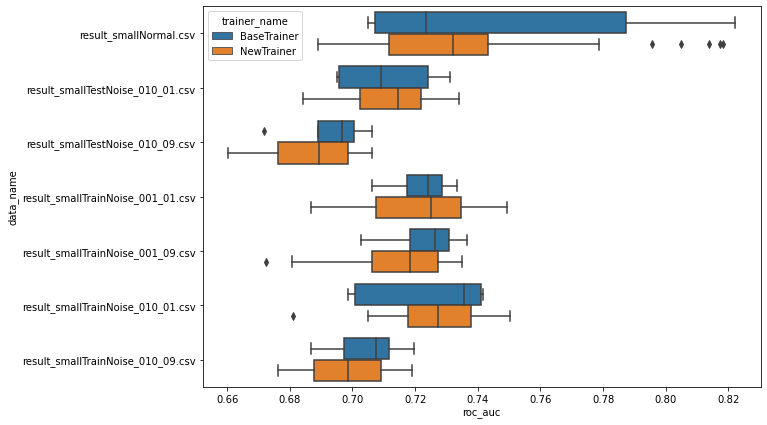

In [80]:
plt.figure(figsize=(10,7))
sns.boxplot(data=result_df, y='data_name', x='roc_auc', hue='trainer_name')

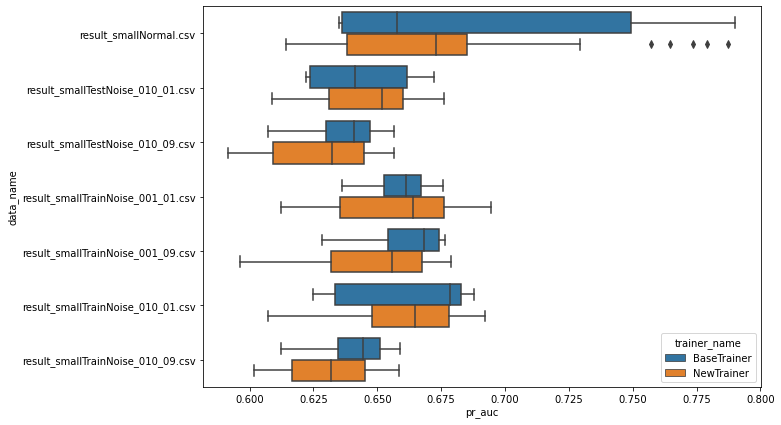

In [81]:
plt.figure(figsize=(10,7))
sns.boxplot(data=result_df, y='data_name', x='pr_auc', hue='trainer_name') 